## Loan DataSet Analysis

### Project Overview
Data:

Dataset obtained from Kaggle.com: https://www.kaggle.com/adarshsng/lending-club-loan-data-csv/version/1

The CSV file contains complete loan data for all loans issued through the 2007-2018, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. Additional features include credit scores, number of finance inquiries, address including zip codes, and state, and collections among others.

### Problem Statement
Among all the loans there is always a good portion of them that eventually turn out to be bad loans. Our goal for this project is, by leveraging the historical data of granted loans with information on whether or not the borrower defaulted, to build a model which can predict whether or nor a borrower will pay back the loan. So we may take the result coming out of this tool into consideration, when they are in determination of whether to approve a loan application from a new customer.

Because the data input contains a great number of features in various types, making the input very complex, I decided to skip the conventional regression methods for modeling. Instead, I'll use Neural Networks with multiple hidden layers, A.K.A Deep Learning.



### Data Overview

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from pickle import dump, load


%matplotlib inline

In [2]:
# Reading the data
# Header is skipped in the lambda by specifying x > 0,
# and np.random.rand()>0.1 is to ensure it reads in about 10% of total data

np.random.seed(101)
df = pd.read_csv(
        'loan.csv', 
        header=0, 
        skiprows = (lambda x: x>0 and np.random.rand()>0.1)
)

C:\Users\fusio\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Saving the sample data as a copy
df.to_csv(
        'sample.csv', 
        index=False
)

In [4]:
# Reading the data dictionary and creating a function to display feature info
df_dict = pd.read_excel(
        'LCDataDictionary.xlsx',
        sheet_name='LoanStats',
        header=0,
        index_col='LoanStatNew'
)

# using the try catch statements to avoid data discrepencies
def feat_info(col_name):
    '''
    INPUT:
    col_name - specific column name of the df
    
    OUTPUT:
    The description of the column is printed
    '''
    try:
        print(df_dict.loc[col_name]['Description'])
        
    except KeyError:
        print(col_name + ' is not found in data dictionary')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225636 entries, 0 to 225635
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 249.6+ MB


In [6]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,7000,7000,7000.0,36 months,12.98,235.80,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,9600,9600,9600.0,36 months,23.40,373.62,E,E1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,20000,20000,20000.0,36 months,12.98,673.69,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,8000,8000,8000.0,36 months,10.72,260.86,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
member_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,225636.0,15061.019740,9191.078763,500.00,8000.0000,13000.000,20000.0000,40000.00
funded_amnt,225636.0,15055.929683,9189.731604,500.00,8000.0000,12950.000,20000.0000,40000.00
funded_amnt_inv,225636.0,15037.947270,9194.350751,0.00,8000.0000,12875.000,20000.0000,40000.00
...,...,...,...,...,...,...,...,...
hardship_payoff_balance_amount,1051.0,11742.202636,7705.382139,206.97,5809.8050,10068.830,16577.8550,40306.41
hardship_last_payment_amount,1051.0,206.404520,208.005855,0.02,47.1400,143.140,317.2450,1283.90
settlement_amount,3396.0,5089.657111,3672.918280,44.21,2328.3175,4205.175,6954.8275,25790.00
settlement_percentage,3396.0,47.717282,6.852588,10.69,45.0000,45.000,50.0000,100.00


### Data Exploration, Visualization and Pre-processing

Figuring out which feature can be the target variable and see if any transformation is needed.

In [8]:
feat_info('loan_status')

Current status of the loan


In [9]:
df['loan_status'].dtype

dtype('O')

In [10]:
df['loan_status'].isnull().mean()

0.0

In [11]:
# Showing it's distribution across categories.
df.groupby('loan_status')['loan_status'].count()/len(df)

loan_status
Charged Off                                            0.115451
Current                                                0.406628
Default                                                0.000004
Does not meet the credit policy. Status:Charged Off    0.000319
Does not meet the credit policy. Status:Fully Paid     0.000917
Fully Paid                                             0.461314
In Grace Period                                        0.003936
Late (16-30 days)                                      0.001720
Late (31-120 days)                                     0.009710
Name: loan_status, dtype: float64

In [12]:
# Re-grouping and transforming 'loan_status' into numeric column
regroup = {
        'Charged Off': 1,
        'Current': 2,
        'Default': 1,
        'Does not meet the credit policy. Status:Charged Off': 1,
        'Does not meet the credit policy. Status:Fully Paid': 0,
        'Fully Paid': 0,
        'In Grace Period': 2,
        'Late (16-30 days)': 2,
        'Late (31-120 days)': 2
}

df['loan_status'] = df['loan_status'].map(regroup)

In [13]:
# Checking the distribution across buckets again
df.groupby('loan_status')['loan_status'].count()/len(df)

loan_status
0    0.462231
1    0.115775
2    0.421994
Name: loan_status, dtype: float64

<AxesSubplot:xlabel='loan_status', ylabel='count'>

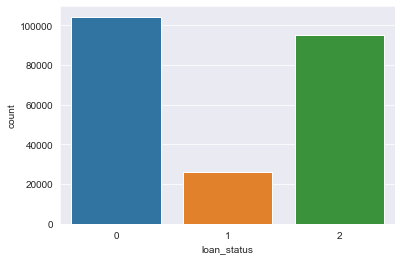

In [14]:
# Visualising the binary 0 vs 1 (ignoring the 2)
sns.set_style('darkgrid')
sns.countplot(x='loan_status', data=df)

<AxesSubplot:>

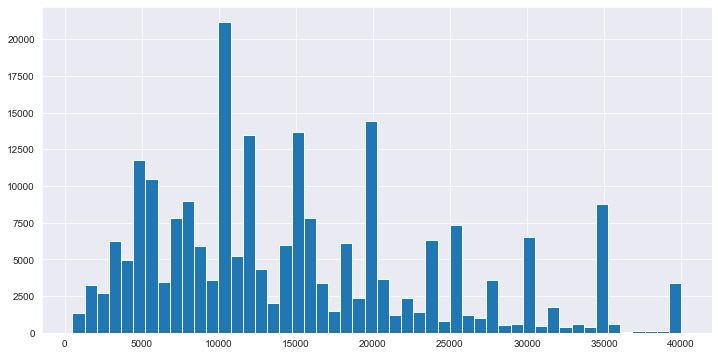

In [15]:
# Looking at the distribution of the loan amount
df['loan_amnt'].hist(figsize=[12,6], bins=50)

In [16]:
# Too many features in the dataset so trying to drop few of the unnecessary ones.

df.columns[df.isnull().mean() >= 0.3]

Index(['id', 'member_id', 'url', 'desc', 'mths_since_last_delinq',
       'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
       'inq_last_12m', 'mths_since_recent_bc_dlq',
       'mths_since_recent_revol_delinq', 'revol_bal_joint',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog', 'hardship_type',
       'hardship_reason', 'hardship_status', 'deferral_term',
       'hardship_amount', 'hardship_start_date', 'hardship_end_d

In [17]:
df = df[df.columns[df.isnull().mean() < 0.3]]

In [18]:
# Displaying the left over columns in the dataset.
df.shape

(225636, 87)

In [19]:
# 87 features are left over.
df.columns.tolist()

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_

In [20]:
# Getting the description of all the 87 features
for col in df.columns.tolist():
    print(col)
    feat_info(col)
    print('\n')


loan_amnt
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.


funded_amnt
The total amount committed to that loan at that point in time.


funded_amnt_inv
The total amount committed by investors for that loan at that point in time.


term
The number of payments on the loan. Values are in months and can be either 36 or 60.


int_rate
Interest Rate on the loan


installment
The monthly payment owed by the borrower if the loan originates.


grade
LC assigned loan grade


sub_grade
LC assigned loan subgrade


emp_title
The job title supplied by the Borrower when applying for the loan.*


emp_length
Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 


home_ownership
The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT

In [21]:
# Dropping some features
to_drop = ['funded_amnt', 'funded_amnt_inv', 'issue_d', 'pymnt_plan', 'out_prncp', 
           'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 
           'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
           'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'policy_code', 
           'disbursement_method', 'hardship_flag', 'debt_settlement_flag', 'total_rev_hi_lim']

df.drop(to_drop, axis=1, inplace=True)

In [22]:
len(df.columns)

66

In [23]:
# Exploring correlation between the continuous variables
df.corr()

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
loan_amnt,1.000000,0.098151,0.945354,0.291679,0.094319,0.043076,-0.009985,-0.028604,0.181860,-0.056225,...,-0.025771,-0.026484,0.089888,0.019655,-0.083958,0.009729,0.330767,0.271233,0.370401,0.208018
int_rate,0.098151,1.000000,0.124550,-0.074936,0.025296,0.122547,0.058793,0.188005,-0.009583,0.052513,...,0.031476,0.180533,-0.081666,0.271791,0.054589,0.013256,-0.124129,0.006950,-0.240334,-0.001799
installment,0.945354,0.124550,1.000000,0.281780,0.046222,0.043107,0.000005,-0.002937,0.171394,-0.044761,...,-0.020008,-0.002960,0.071120,0.042842,-0.075806,0.016275,0.295462,0.254125,0.333954,0.190718
annual_inc,0.291679,-0.074936,0.281780,1.000000,0.015484,-0.118783,0.039405,0.030870,0.141984,-0.004119,...,0.007832,0.049931,-0.008166,-0.005143,-0.041716,0.035417,0.394871,0.315766,0.265729,0.266330
loan_status,0.094319,0.025296,0.046222,0.015484,1.000000,0.057783,-0.007863,-0.098412,0.009229,-0.026596,...,-0.011728,-0.042525,-0.012606,-0.070624,-0.012529,-0.011593,0.007364,0.028855,0.059937,0.039164
dti,0.043076,0.122547,0.043107,-0.118783,0.057783,1.000000,-0.011063,-0.011677,0.183701,-0.024977,...,-0.013121,0.045339,0.062293,0.098864,-0.013661,-0.017060,0.029116,0.185854,0.039696,0.212497
delinq_2yrs,-0.009985,0.058793,0.000005,0.039405,-0.007863,-0.011063,1.000000,0.024017,0.047916,-0.020787,...,0.661076,-0.025805,-0.439914,0.001059,-0.049214,0.010672,0.054109,0.026864,-0.080398,0.056268
inq_last_6mths,-0.028604,0.188005,-0.002937,0.030870,-0.098412,-0.011677,0.024017,1.000000,0.139223,0.068152,...,0.032815,0.328342,-0.027832,-0.063292,0.075241,0.016155,0.033448,0.039646,-0.000071,0.044656
open_acc,0.181860,-0.009583,0.171394,0.141984,0.009229,0.183701,0.047916,0.139223,1.000000,-0.013796,...,0.007755,0.373340,0.109492,-0.084916,-0.018258,-0.002913,0.299285,0.405898,0.383547,0.372407
pub_rec,-0.056225,0.052513,-0.044761,-0.004119,-0.026596,-0.024977,-0.020787,0.068152,-0.013796,1.000000,...,-0.004210,0.082446,-0.011657,-0.030515,0.646110,0.706502,-0.064829,-0.049569,-0.124256,-0.019882


<AxesSubplot:>

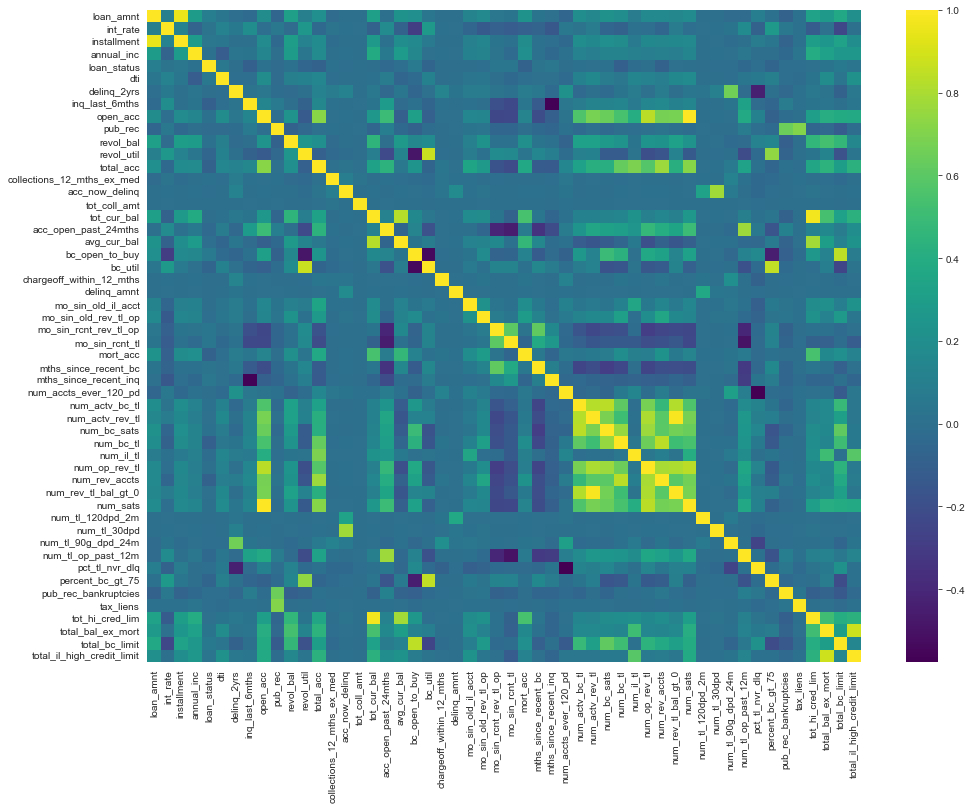

In [24]:
# Visualizing the correlation
plt.figure(
        figsize=[16,12]
)

sns.heatmap(
        data=df.corr(), 
        cmap='viridis', 
        annot=False, 
        fmt='.2g'
)

In [25]:
to_drop2 = [
        'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 
        'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
        'tot_hi_cred_lim', 'bc_util', 'installment'
]

df.drop(to_drop2, axis=1, inplace=True)

In [26]:
# Dealing with both the numeric and string features
df.select_dtypes('object').head(10)

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type
0,36 months,D,D1,Administrative,6 years,MORTGAGE,Source Verified,debt_consolidation,Debt consolidation,490xx,MI,Apr-2011,w,Individual
1,36 months,B,B5,Worship Director,4 years,MORTGAGE,Not Verified,house,Home buying,436xx,OH,Dec-2002,w,Individual
2,36 months,E,E1,driver coordinator,9 years,RENT,Not Verified,credit_card,Credit card refinancing,265xx,WV,Sep-2003,f,Individual
3,36 months,B,B5,FC,5 years,RENT,Not Verified,debt_consolidation,Debt consolidation,618xx,IL,Aug-1989,w,Individual
4,36 months,B,B2,Publications and Images Project Manager,10+ years,MORTGAGE,Source Verified,car,Car financing,802xx,CO,Jul-1986,w,Individual
5,36 months,B,B1,Agent,2 years,OWN,Not Verified,debt_consolidation,Debt consolidation,371xx,TN,Feb-2005,w,Individual
6,36 months,B,B2,Administrative Assistant,10+ years,RENT,Not Verified,credit_card,Credit card refinancing,925xx,CA,Oct-2007,w,Individual
7,36 months,B,B2,Teacher,10+ years,MORTGAGE,Not Verified,debt_consolidation,Debt consolidation,919xx,CA,May-2005,w,Individual
8,36 months,C,C4,lab tech,10+ years,OWN,Source Verified,home_improvement,Home improvement,280xx,NC,Nov-2014,w,Individual
9,36 months,C,C1,NaN,NaN,OWN,Source Verified,home_improvement,Home improvement,425xx,KY,Aug-1998,w,Joint App


In [27]:
df.drop(['title','grade'], axis=1, inplace=True)

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

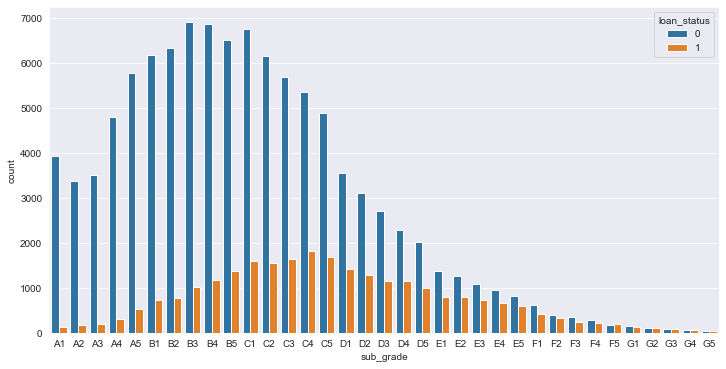

In [28]:
# Exploring if this grading information can shed some light on the Good/Bad loan question?

order = sorted(
        df['sub_grade'].unique()
)

plt.figure(
        figsize=[12,6]
)

sns.countplot(
        x='sub_grade', 
        hue='loan_status', 
        data=df[df['loan_status'] != 2], 
        order=order
)

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

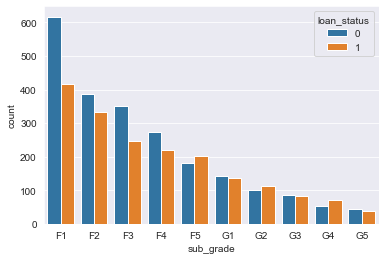

In [29]:
# The graph shows F and G groups seem to have high default rate

order = sorted(
        df['sub_grade'][df['sub_grade'].str[0].isin(['F','G'])].unique()
)

sns.countplot(
        x='sub_grade', 
        hue='loan_status', 
        data=df[(df['sub_grade'].str[0].isin(['F','G'])) & (df['loan_status'] != 2)], 
        order=order
)

In [30]:
df.head()

,loan_amnt,term,int_rate,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,5000,36 months,17.97,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,2,...,0.0,0.0,0.0,100.0,0.0,0.0,0.0,11749.0,13800.0,10000.0
1,7000,36 months,12.98,B5,Worship Director,4 years,MORTGAGE,102500.0,Not Verified,2,...,0.0,0.0,2.0,80.0,0.0,0.0,0.0,76709.0,7200.0,96826.0
2,9600,36 months,23.40,E1,driver coordinator,9 years,RENT,65000.0,Not Verified,2,...,0.0,0.0,1.0,90.0,85.7,0.0,0.0,24165.0,7600.0,40402.0
3,20000,36 months,12.98,B5,FC,5 years,RENT,74800.0,Not Verified,2,...,0.0,0.0,0.0,100.0,100.0,0.0,0.0,39977.0,28700.0,18000.0
4,8000,36 months,10.72,B2,Publications and Images Project Manager,10+ years,MORTGAGE,82923.0,Source Verified,2,...,0.0,0.0,1.0,80.0,50.0,0.0,0.0,72223.0,22300.0,59007.0


In [31]:
df.isnull().mean()

loan_amnt                     0.000000
term                          0.000000
int_rate                      0.000000
sub_grade                     0.000000
emp_title                     0.073836
emp_length                    0.065313
home_ownership                0.000000
annual_inc                    0.000000
verification_status           0.000000
loan_status                   0.000000
purpose                       0.000000
zip_code                      0.000000
addr_state                    0.000000
dti                           0.000718
delinq_2yrs                   0.000013
earliest_cr_line              0.000013
inq_last_6mths                0.000013
open_acc                      0.000013
pub_rec                       0.000013
revol_bal                     0.000000
revol_util                    0.000767
total_acc                     0.000013
initial_list_status           0.000000
collections_12_mths_ex_med    0.000075
application_type              0.000000
acc_now_delinq           

In [32]:
# Displaying unique employment data
df['emp_title'].nunique()

81346

In [33]:
df.drop('emp_title',axis=1,inplace=True)

<AxesSubplot:xlabel='emp_length', ylabel='count'>

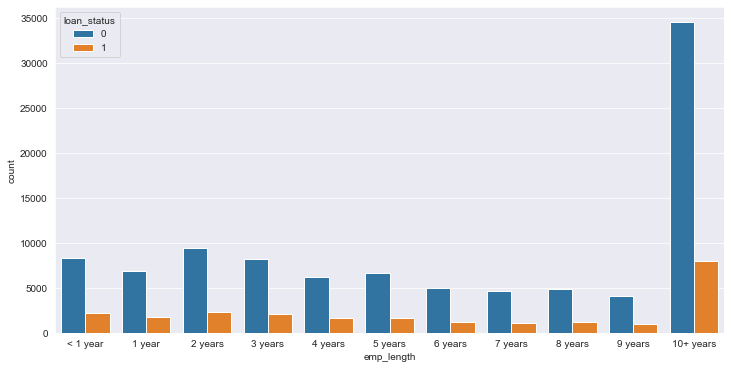

In [34]:
# Visualizing the 'emp_length' feature.

order_df = pd.DataFrame(
        df['emp_length'].unique(), 
        columns=['emp_length']
)

order_df.dropna(
        inplace=True
)

order_df['num order'] = order_df['emp_length'].str.rsplit(n=1,expand=True)[0]


def trans(text):
    '''
    INPUT:
    text - the values of the emp_length feature
    
    OUTPUT:
    numbers for python to sort better
    '''
    if text == '10+':
        return '10'
    elif text =='< 1':
        return '0'
    else:
        return text

order_df['num order'] = order_df['num order'].map(trans, na_action='ignore').astype('int')
order_df = order_df.sort_values('num order')

order = order_df['emp_length']

# Plotting
plt.figure(
        figsize=[12,6]
)

sns.countplot(
        x='emp_length', 
        data=df[df['loan_status'] != 2], 
        order=order, 
        hue='loan_status'
)

In [35]:
df.drop('emp_length',axis=1, inplace=True)

In [36]:
# Checking if any row entries have missing values across many features. These entries can be dropped, if any.
df.transpose().isnull().mean().sort_values(ascending=False)

213735    0.705882
213733    0.705882
213734    0.705882
213456    0.529412
213730    0.529412
            ...   
82582     0.000000
82583     0.000000
82584     0.000000
82585     0.000000
225635    0.000000
Length: 225636, dtype: float64

In [37]:
# Dropping the rows with high % of missing values across columns
# with non-NaN values for at least 40 columns

df.dropna(axis=0, thresh=40, inplace=True)

In [38]:
df.dtypes[df.isnull().any()]

dti                      float64
revol_util               float64
avg_cur_bal              float64
bc_open_to_buy           float64
mo_sin_old_il_acct       float64
mths_since_recent_bc     float64
mths_since_recent_inq    float64
num_tl_120dpd_2m         float64
pct_tl_nvr_dlq           float64
percent_bc_gt_75         float64
dtype: object

In [39]:
# Getting the description of all the features with NaN

for col in df.columns[df.isnull().any()].tolist():
    print(col)
    feat_info(col)
    print('\n')

dti
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.


revol_util
Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.


avg_cur_bal
Average current balance of all accounts


bc_open_to_buy
Total open to buy on revolving bankcards.


mo_sin_old_il_acct
Months since oldest bank installment account opened


mths_since_recent_bc
Months since most recent bankcard account opened.


mths_since_recent_inq
Months since most recent inquiry.


num_tl_120dpd_2m
Number of accounts currently 120 days past due (updated in past 2 months)


pct_tl_nvr_dlq
Percent of trades never delinquent


percent_bc_gt_75
Percentage of all bankcard accounts > 75% of limit.




In [40]:
# Filling Nan with 0s
df.fillna(0.0, inplace=True)

# Checking it again
df.isnull().any()

loan_amnt                     False
term                          False
int_rate                      False
sub_grade                     False
home_ownership                False
annual_inc                    False
verification_status           False
loan_status                   False
purpose                       False
zip_code                      False
addr_state                    False
dti                           False
delinq_2yrs                   False
earliest_cr_line              False
inq_last_6mths                False
open_acc                      False
pub_rec                       False
revol_bal                     False
revol_util                    False
total_acc                     False
initial_list_status           False
collections_12_mths_ex_med    False
application_type              False
acc_now_delinq                False
tot_coll_amt                  False
tot_cur_bal                   False
acc_open_past_24mths          False
avg_cur_bal                 

In [41]:
# Listing all the columns that are strings.
df_str = df.select_dtypes('object').columns.tolist()
df_str

['term',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'application_type']

In [42]:
# Showing how many categories each of them has

for i in df_str:
    print(i, ' = ', df[i].nunique())

term  =  2
sub_grade  =  35
home_ownership  =  6
verification_status  =  3
purpose  =  13
zip_code  =  885
addr_state  =  50
earliest_cr_line  =  673
initial_list_status  =  2
application_type  =  2


In [43]:
df.drop(['zip_code', 'earliest_cr_line', 'addr_state'],axis=1, inplace=True)

In [44]:
# Seeing if any categorical features can be transformed into numeric
df['term'].value_counts()

 36 months    155286
 60 months     63376
Name: term, dtype: int64

In [45]:
# Transforming 'term' column to numeric
df['term'] = df['term'].str.split(expand=True)[0].astype('int')

In [46]:
df['home_ownership'].value_counts()

MORTGAGE    107626
RENT         86282
OWN          24651
ANY             94
NONE             6
OTHER            3
Name: home_ownership, dtype: int64

In [47]:

def trans(text):
    '''
    INPUT:
    test - the categorical values for 'home_ownership'
    
    OUTPUT:
    replace NONE and ANY with OTHER
    '''
    if text in ['OTHER', 'NONE', 'ANY']:
        return 'OTHER'
    else:
        return text
    
df['home_ownership'] = df['home_ownership'].apply(trans)
df['home_ownership'].value_counts()

MORTGAGE    107626
RENT         86282
OWN          24651
OTHER          103
Name: home_ownership, dtype: int64

In [48]:
# Creating fake variables
df_str1 = df.select_dtypes('object').columns.tolist()

df = pd.get_dummies(
        df, 
        columns=df_str1, 
        drop_first=True
)

In [49]:
# Checking if there are any categorical features left
df.select_dtypes('object').columns.tolist()

[]

### Modeling
#### Deep Learning Implementation

In [50]:
# Setting aside the 2 for loan_status, leaving only 0 and 1
to_train = df[df['loan_status'].isin([0,1])]
to_pred = df[df['loan_status'] == 2]
print(type(to_pred))
print(to_pred)

<class 'pandas.core.frame.DataFrame'>
        loan_amnt  term  int_rate  annual_inc  loan_status    dti  \
0            5000    36     17.97     59280.0            2  10.51   
1            7000    36     12.98    102500.0            2  15.20   
2            9600    36     23.40     65000.0            2  23.01   
3           20000    36     12.98     74800.0            2  23.50   
4            8000    36     10.72     82923.0            2  18.55   
...           ...   ...       ...         ...          ...    ...   
225629      20000    36     20.00     70000.0            2  39.62   
225630      29200    36     24.85    150000.0            2  26.43   
225632      22450    36     20.00     98600.0            2  31.24   
225633      23375    36     21.45     80000.0            2  20.70   
225635       3500    36     10.91     21000.0            2  24.80   

        delinq_2yrs  inq_last_6mths  open_acc  pub_rec  ...  \
0               0.0             0.0       8.0      0.0  ...   
1      

In [51]:
# Train Test Splitting
X = to_train.drop('loan_status', axis=1).values
y = to_train['loan_status'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 101)

In [52]:
# Normalizing the Data with MinMaxScaler
# To fit and transform the train data only transforming the test data without fit

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
X_train.shape

(86411, 94)

In [54]:
# Building the model

model = Sequential()

model.add(
        Dense(94, activation='relu')
)

model.add(
        Dense(30, activation='relu')
)

model.add(
        Dense(15, activation='relu')
)


model.add(
        Dense(1, activation='sigmoid')
)

model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy']
)

In [55]:
# Training it
# Use early_stop to prevent too much over fitting

early_stop = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1, 
        patience=25
)

model.fit(
        X_train, 
        y_train, 
        epochs=200, 
        batch_size=256, 
        validation_data=(X_test, y_test),
         callbacks=[early_stop]
)

Epoch 1/200
338/338 [==============================] - 1s 1ms/step - loss: 0.4792 - accuracy: 0.7960 - val_loss: 0.4617 - val_accuracy: 0.7977
Epoch 2/200
338/338 [==============================] - 0s 771us/step - loss: 0.4590 - accuracy: 0.7984 - val_loss: 0.4600 - val_accuracy: 0.7982
Epoch 3/200
338/338 [==============================] - 0s 772us/step - loss: 0.4574 - accuracy: 0.7997 - val_loss: 0.4590 - val_accuracy: 0.7985
Epoch 4/200
338/338 [==============================] - 0s 769us/step - loss: 0.4561 - accuracy: 0.7996 - val_loss: 0.4586 - val_accuracy: 0.7989
Epoch 5/200
338/338 [==============================] - 0s 781us/step - loss: 0.4550 - accuracy: 0.8002 - val_loss: 0.4586 - val_accuracy: 0.7989
Epoch 6/200
338/338 [==============================] - 0s 760us/step - loss: 0.4540 - accuracy: 0.8007 - val_loss: 0.4579 - val_accuracy: 0.7991
Epoch 7/200
338/338 [==============================] - 0s 766us/step - loss: 0.4530 - accuracy: 0.8012 - val_loss: 0.4585 - val_accu

### Model Evaluation and Validation

<AxesSubplot:>

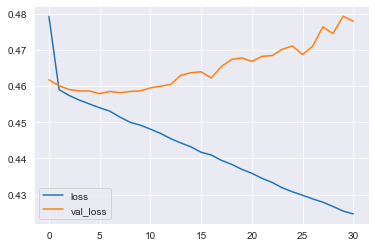

In [56]:
# Plotting the loss
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

In [57]:
# Showing the classification report
predictions = model.predict((X_test)>0.5).astype('int32')

print(
        confusion_matrix(y_test,predictions), 
        '\n', 
        classification_report(y_test,predictions)
)

[[29529     0]
 [ 7505     0]] 
               precision    recall  f1-score   support

           0       0.80      1.00      0.89     29529
           1       0.00      0.00      0.00      7505

    accuracy                           0.80     37034
   macro avg       0.40      0.50      0.44     37034
weighted avg       0.64      0.80      0.71     37034



C:\Users\fusio\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fusio\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fusio\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [58]:
# Refining the model

model_new = Sequential()

model_new.add(
        Dense(94, activation='relu')
)

model_new.add(Dropout(0.2))

model_new.add(
        Dense(30, activation='relu')
)

model_new.add(Dropout(0.2))

model_new.add(
        Dense(15, activation='relu')
)

model_new.add(Dropout(0.2))

model_new.add(
        Dense(1, activation='sigmoid')
)

model_new.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['binary_accuracy']
)


model_new.fit(
        X_train, 
        y_train, 
        epochs=200, 
        batch_size=256, 
        validation_data=(X_test, y_test),
         callbacks=[early_stop]
)

Epoch 1/200
338/338 [==============================] - 1s 1ms/step - loss: 0.4915 - binary_accuracy: 0.7929 - val_loss: 0.4631 - val_binary_accuracy: 0.7973
Epoch 2/200
338/338 [==============================] - 0s 1ms/step - loss: 0.4681 - binary_accuracy: 0.7972 - val_loss: 0.4617 - val_binary_accuracy: 0.7984
Epoch 3/200
338/338 [==============================] - 0s 1ms/step - loss: 0.4656 - binary_accuracy: 0.7985 - val_loss: 0.4600 - val_binary_accuracy: 0.7980
Epoch 4/200
338/338 [==============================] - 0s 1ms/step - loss: 0.4639 - binary_accuracy: 0.7991 - val_loss: 0.4596 - val_binary_accuracy: 0.7979
Epoch 5/200
338/338 [==============================] - 0s 1ms/step - loss: 0.4627 - binary_accuracy: 0.7981 - val_loss: 0.4593 - val_binary_accuracy: 0.7985
Epoch 6/200
338/338 [==============================] - 0s 1ms/step - loss: 0.4612 - binary_accuracy: 0.7985 - val_loss: 0.4588 - val_binary_accuracy: 0.7985
Epoch 7/200
338/338 [==============================] - 0s 

<AxesSubplot:>

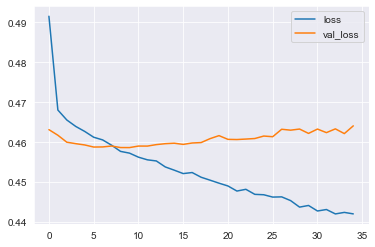

In [59]:
# Plotting the loss
pd.DataFrame(model_new.history.history)[['loss','val_loss']].plot()

In [60]:
# Changing the cut-off line to decrease Type 2 error

predictions_new = (model_new.predict(X_test) >= 0.2).astype('int')

print(
        confusion_matrix(y_test,predictions_new), 
        '\n', 
        classification_report(y_test,predictions_new)
)

[[19054 10475]
 [ 2629  4876]] 
               precision    recall  f1-score   support

           0       0.88      0.65      0.74     29529
           1       0.32      0.65      0.43      7505

    accuracy                           0.65     37034
   macro avg       0.60      0.65      0.59     37034
weighted avg       0.77      0.65      0.68     37034



In [61]:
# Saving the model and scaler
dump(scaler, open('scaler.pkl', 'wb'))
model_new.save('my_model_lending_club.h5')

In [62]:
# Model Use Case
# Predicting the OOT sample
later_scaler = load(open('scaler.pkl', 'rb'))
later_model = load_model('my_model_lending_club.h5')

X_OOT = to_pred.drop('loan_status', axis=1).values
X_OOT = later_scaler.transform(X_OOT)

predictions_OOT = (later_model.predict(X_OOT) >= 0.2).astype('int')
print(len(predictions_OOT))
print(predictions_OOT)

95217
[[0]
 [0]
 [1]
 ...
 [1]
 [1]
 [0]]


In [64]:
# loan_amnt = 5000
# term = 36
# int_rate = 17.97
# annual_inc = 59280
# loan_status = 2
# dti = 10.51
# delinq_2yrs = 0.0
# inq_last_6mths = 0.0
# open_acc = 8.0
# pub_rec = 0.0
# purpose_major_purchase = 0.0
# purpose_medical = 0
# purpose_moving = 0
# purpose_other = 0
# purpose_renewable_energy = 0
# purpose_small_business = 0
# purpose_vacation = 0
# purpose_wedding = 0
# initial_list_status_w = 1
# application_type_Joint = 0
# # pd.DataFrame([[pi,e,phi]],columns=['pi','e','phi'])
# later_scaler = load(open('scaler.pkl', 'rb'))
# later_model = load_model('my_model_lending_club.h5')

# X_OOT = pd.DataFrame([[loan_amnt,term,int_rate,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,
# pub_rec,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,
# purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_Joint]],columns=[5000,
# 36,17.97,59280,2,10.51,0.0,0,8.0,0.0,0.0,0,0,0,0,0,0,0,1,0])




# X_OOT = later_scaler.transform(X_OOT)

# predictions_OOT = (later_model.predict(X_OOT) >= 0.2).astype('int')
# print(len(predictions_OOT))
# print(predictions_OOT)
# # df = pd.DataFrame(data,columns=['Name','Age'])